In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
all_user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")

all_pr_df.head()


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264016139,1688,`metta code` --> `metta clip` and additional p...,Remove unused `root_key` variable to fix ruff ...,Claude_Code,37011,jacklionheart,closed,2025-07-25T18:15:36Z,2025-07-25T19:17:23Z,2025-07-25T19:17:23Z,8.439884e+08,https://api.github.com/repos/Metta-AI/metta,https://github.com/Metta-AI/metta/pull/1688
1,3264021033,41,feat: Comprehensive ruff error resolution with...,## 🎯 Mission Accomplished: 100% Ruff Error Res...,Claude_Code,131842369,Draco3310,open,2025-07-25T18:17:57Z,None,None,9.920635e+08,https://api.github.com/repos/Draco3310/Gal-Fri...,https://github.com/Draco3310/Gal-Friday2/pull/41
2,3264042289,1600,Add Evals frontend implementation plan and HTM...,\nCreate comprehensive implementation plan for...,Claude_Code,6766889,justicart,closed,2025-07-25T18:26:15Z,2025-07-25T23:19:14Z,None,9.267118e+08,https://api.github.com/repos/bolt-foundry/bolt...,https://github.com/bolt-foundry/bolt-foundry/p...
3,3264042318,1601,Add 4 new BfDs components for Evals interface ...,\nPhase 1 component creation for the Evals fro...,Claude_Code,6766889,justicart,closed,2025-07-25T18:26:16Z,2025-07-25T23:19:11Z,None,9.267118e+08,https://api.github.com/repos/bolt-foundry/bolt...,https://github.com/bolt-foundry/bolt-foundry/p...
4,3264067496,3,🚀 Complete Frontend-Backend API Integration wi...,## 🎯 Summary\n\nThis PR completes the **fronte...,Claude_Code,42357482,twitchyvr,closed,2025-07-25T18:39:14Z,2025-07-25T18:48:47Z,2025-07-25T18:48:47Z,1.025871e+09,https://api.github.com/repos/twitchyvr/Spaghetti,https://github.com/twitchyvr/Spaghetti/pull/3


RQ1: What are the key profiles of developers adopting AI coding agents for pull requests, and how do these profiles vary by primary AI agent used?

In [2]:
all_pr_df["created_at"] = pd.to_datetime(all_pr_df["created_at"])
all_user_df["created_at"] = pd.to_datetime(all_user_df["created_at"])

In [3]:
user_pr_count = all_pr_df.groupby("user_id").size().reset_index(name="num_prs")

In [4]:
user_agents = all_pr_df.groupby("user_id")["agent"].nunique().reset_index(name="num_agents_used")

In [5]:
user_main_agent = all_pr_df.groupby("user_id")["agent"].agg(lambda x: x.value_counts().idxmax()).reset_index(name="main_agent")

In [6]:
user_repos = all_pr_df.groupby("user_id")["repo_id"].nunique().reset_index(name="repos_contributed")

In [7]:
all_pr_df["created_at"] = pd.to_datetime(all_pr_df["created_at"])

pr_dates = all_pr_df.groupby("user_id")["created_at"].agg(["min", "max", "count"])

# diferencia en días
pr_dates["days_active"] = (pr_dates["max"] - pr_dates["min"]).dt.days

# evitar división por 0
pr_dates["days_active"] = pr_dates["days_active"].clip(lower=1)

# pasar días → meses (promedio 30.44 días por mes)
pr_dates["months_active"] = pr_dates["days_active"] / 30.44

pr_dates["prs_per_month"] = pr_dates["count"] / pr_dates["months_active"]

pr_dates = pr_dates.reset_index()[["user_id", "prs_per_month"]]

pr_dates.head()

,user_id,prs_per_month
0,17,6.873548
1,19,60.880000
2,27,5.534545
3,70,30.440000
4,93,30.440000


In [8]:
all_user_df["created_at"] = pd.to_datetime(all_user_df["created_at"]).dt.tz_localize(None)

user_account_age = all_user_df.copy()

now = pd.Timestamp.now()

user_account_age["account_age_days"] = (now - user_account_age["created_at"]).dt.days

# Convertir a años (promedio año = 365.25 días)
user_account_age["account_age_years"] = user_account_age["account_age_days"] / 365.25

user_account_age = user_account_age[["id", "account_age_years"]]

user_account_age.head()

,id,account_age_years
0,149159513.0,2.097194
1,86906973.0,4.410678
2,36679210.0,7.775496
3,201261210.0,0.752909
4,22735204.0,9.141684


In [9]:
user_features = all_user_df.merge(user_pr_count, left_on="id", right_on="user_id", how="left")
user_features = user_features.merge(user_agents, on="user_id", how="left")
user_features = user_features.merge(user_main_agent, on="user_id", how="left")
user_features = user_features.merge(user_repos, on="user_id", how="left")
user_features = user_features.merge(pr_dates, on="user_id", how="left")
user_features = user_features.merge(user_account_age, left_on="id", right_on="id", how="left")

user_features = user_features.fillna(0)
user_features.head()

,id,login,followers,following,created_at,user_id,num_prs,num_agents_used,main_agent,repos_contributed,prs_per_month,account_age_years
0,149159513.0,00012122Cs,0.0,0.0,2023-10-27 10:22:50,149159513.0,3.0,1.0,OpenAI_Codex,1.0,91.32,2.097194
1,86906973.0,000Sean000,0.0,2.0,2021-07-04 07:05:40,86906973.0,1.0,1.0,OpenAI_Codex,1.0,30.44,4.410678
2,36679210.0,000alen,46.0,106.0,2018-02-20 21:00:55,36679210.0,2.0,1.0,Cursor,1.0,60.88,7.775496
3,201261210.0,000qhrey,0.0,1.0,2025-02-28 16:53:21,201261210.0,2.0,1.0,OpenAI_Codex,2.0,60.88,0.752909
4,22735204.0,00125495,0.0,1.0,2016-10-10 01:24:34,22735204.0,1.0,1.0,Cursor,1.0,30.44,9.141684


In [10]:
agent_distribution = all_pr_df.groupby("agent")["user_id"].nunique().reset_index(name="num_users")
agent_distribution

,agent,num_users
0,Claude_Code,1643
1,Copilot,379
2,Cursor,9658
3,Devin,1
4,OpenAI_Codex,61653


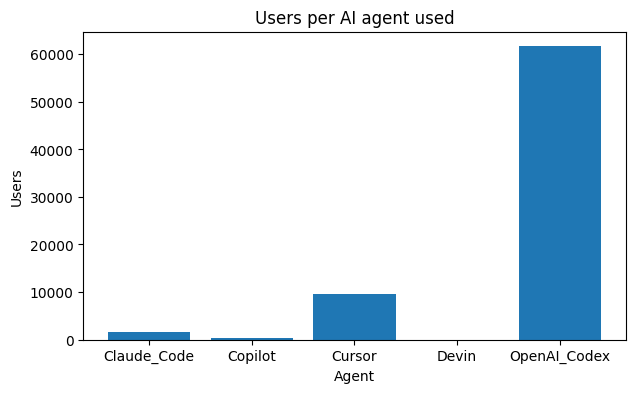

In [11]:
plt.figure(figsize=(7,4))
plt.bar(agent_distribution["agent"], agent_distribution["num_users"])
plt.title("Users per AI agent used")
plt.xlabel("Agent")
plt.ylabel("Users")
plt.show()

In [12]:
grouped = user_features.groupby("main_agent")[["followers", "account_age_years", "num_prs", "prs_per_month"]].mean()
grouped

,followers,account_age_years,num_prs,prs_per_month
main_agent,,,,
0,0.000000,0.000000,0.000000,0.000000
Claude_Code,91.015225,9.562551,3.438754,34.774969
Copilot,51.450000,6.434054,1.629412,39.045243
Cursor,38.458094,5.153129,3.512826,48.567023
Devin,0.000000,1.834360,29746.000000,4153.524037
OpenAI_Codex,18.227122,5.929761,13.292792,81.370928


In [19]:
# ========================================
# 1. IMPORTS Y CONFIGURACIÓN
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from math import pi
import warnings
warnings.filterwarnings("ignore")

# Estilo
plt.style.use('default')
sns.set_palette("deep")

In [20]:
# ========================================
# 2. FILTRAR USUARIOS ACTIVOS (≥3 PRs con IA)
# ========================================
print("Filtrando usuarios con al menos 3 PRs con IA...")
active_users = user_features[user_features['num_prs'] >= 3].copy()
print(f"→ Usuarios activos: {len(active_users):,} (de {len(user_features):,} totales)")

if len(active_users) == 0:
    raise ValueError("No hay usuarios con ≥3 PRs. Baja el filtro a 1 o 2.")

Filtrando usuarios con al menos 3 PRs con IA...
→ Usuarios activos: 30,082 (de 72,651 totales)


In [21]:
# ========================================
# 3. PREPARAR VARIABLES + TRANSFORMACIÓN
# ========================================
feature_cols = [
    'followers',
    'account_age_years',
    'num_prs',
    'prs_per_month',
    'num_agents_used',
    'repos_contributed'
]

X = active_users[feature_cols].copy()

# Log-transform para reducir skew
log_cols = ['followers', 'num_prs', 'prs_per_month', 'repos_contributed']
for col in log_cols:
    X[col] = np.log1p(X[col])

# Escalado robusto (mejor con outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print("Variables transformadas y escaladas.")

Variables transformadas y escaladas.


Probando k desde 2 hasta 7...


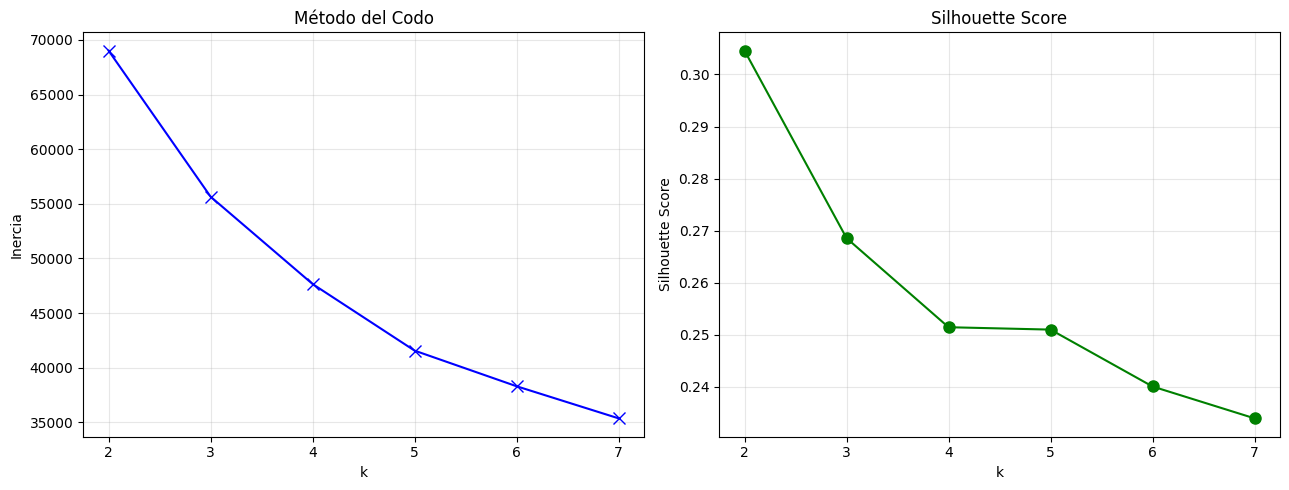

→ K óptimo (Silhouette): 2 (score: 0.305)


In [ ]:
# ========================================
# 4. ENCONTRAR K ÓPTIMO (Elbow + Silhouette)
# ========================================
inertias = []
sil_scores = []
K_range = range(2, min(8, len(active_users)//10 + 1))  # máx razonable

print(f"Probando k desde {K_range[0]} hasta {K_range[-1]}...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(K_range, inertias, 'bx-', markersize=8)
ax1.set_xlabel('k')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del Codo')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, sil_scores, 'go-', markersize=8)
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

"""# Elegir k: mayor Silhouette
optimal_k = K_range[np.argmax(sil_scores)]
print(f"→ K óptimo (Silhouette): {optimal_k} (score: {max(sil_scores):.3f})")"""

In [31]:
# ========================================
# 5. APLICAR KMEANS CON K ÓPTIMO
# ========================================
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
active_users['cluster'] = kmeans.fit_predict(X_scaled)

# Centroides en escala original
centroids_raw = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=feature_cols
)

# Revertir log
centroids = centroids_raw.copy()
for col in log_cols:
    centroids[col] = np.expm1(centroids[col])

centroids = centroids.round(2)
centroids.index.name = 'Cluster'
print("\nCENTROIDES (valores reales):")
display(centroids)


CENTROIDES (valores reales):


,followers,account_age_years,num_prs,prs_per_month,num_agents_used,repos_contributed
Cluster,,,,,,
0,21.27,10.72,6.86,37.41,1.06,1.51
1,1.34,5.58,44.35,70.97,1.05,3.34
2,0.50,4.58,7.02,76.48,1.02,1.20


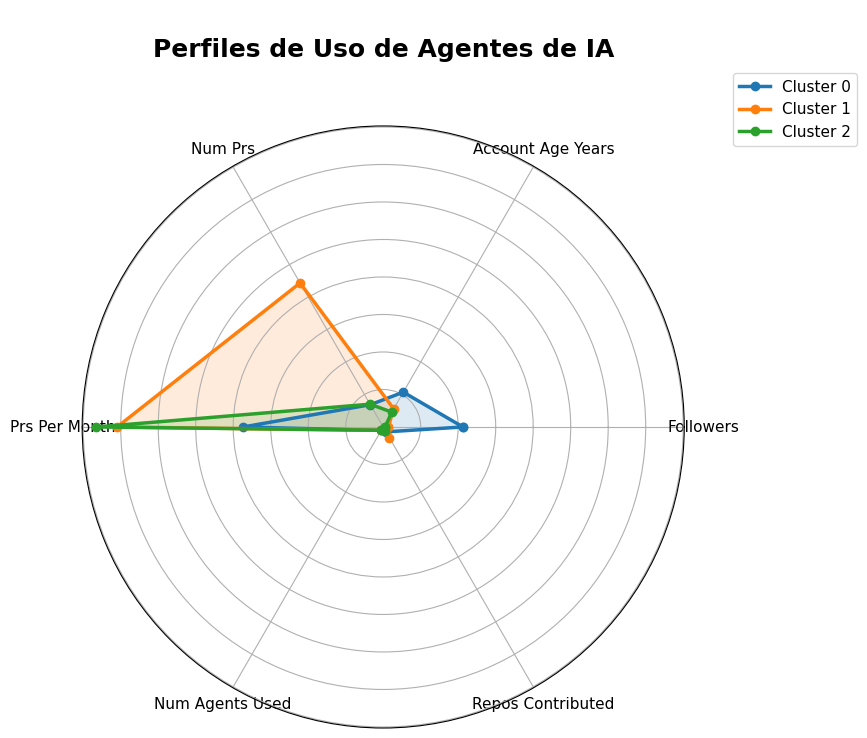

In [32]:
# ========================================
# 6. RADAR PLOT: PERFILES CLAROS
# ========================================
categories = feature_cols
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='polar'))

colors = plt.cm.tab10.colors[:optimal_k]
for i in range(optimal_k):
    values = centroids.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2.5, label=f'Cluster {i}', color=colors[i])
    ax.fill(angles, values, alpha=0.15, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels([col.replace('_', ' ').title() for col in categories], fontsize=11)
ax.set_yticklabels([])
ax.set_title("\nPerfiles de Uso de Agentes de IA\n", size=18, weight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.tight_layout()
plt.show()

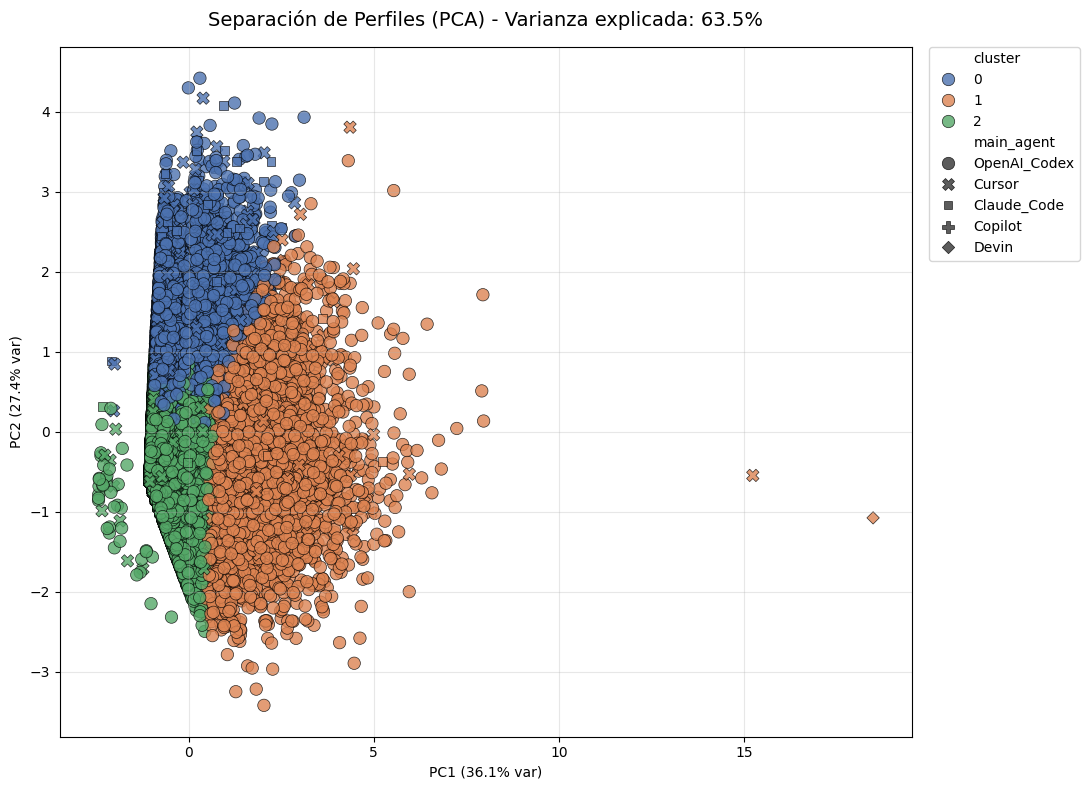

In [33]:
# ========================================
# 7. PCA 2D: SEPARACIÓN VISUAL
# ========================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=active_users.index)
pca_df['cluster'] = active_users['cluster'].values
pca_df['main_agent'] = active_users['main_agent'].values

plt.figure(figsize=(11, 8))
sns.scatterplot(
    data=pca_df, x='PC1', y='PC2',
    hue='cluster', style='main_agent',
    palette='deep', s=80, alpha=0.8, edgecolor='k', linewidth=0.5
)
plt.title(f'Separación de Perfiles (PCA) - Varianza explicada: {pca.explained_variance_ratio_.sum():.1%}', size=14, pad=15)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

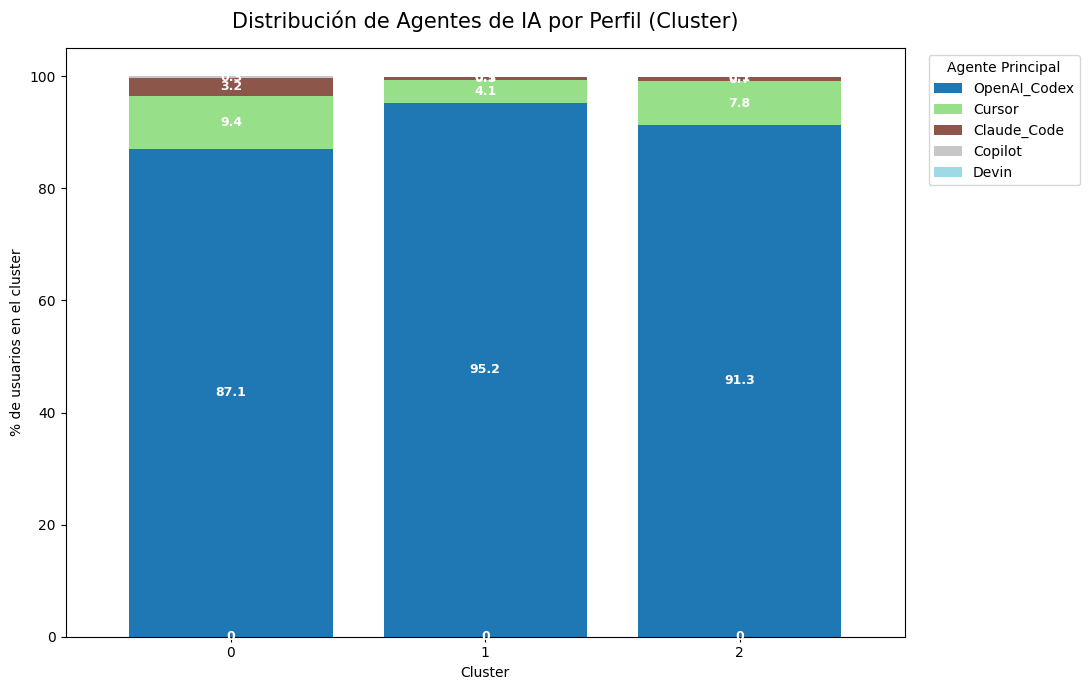


Porcentajes por cluster:


main_agent,OpenAI_Codex,Cursor,Claude_Code,Copilot,Devin
cluster,,,,,
0,87.1,9.4,3.2,0.3,0.0
1,95.2,4.1,0.5,0.1,0.0
2,91.3,7.8,0.7,0.1,0.0


In [34]:
# ========================================
# 8. DISTRIBUCIÓN DE AGENTES POR CLUSTER
# ========================================
agent_dist = active_users.groupby(['cluster', 'main_agent']).size().unstack(fill_value=0)
agent_dist_pct = agent_dist.div(agent_dist.sum(axis=1), axis=0) * 100
agent_dist_pct = agent_dist_pct.round(1)

# Ordenar columnas por frecuencia total
agent_order = active_users['main_agent'].value_counts().index
agent_dist_pct = agent_dist_pct.reindex(columns=agent_order)

ax = agent_dist_pct.plot(
    kind='bar', stacked=True, figsize=(11, 7), colormap='tab20', width=0.8
)
plt.title('Distribución de Agentes de IA por Perfil (Cluster)', size=15, pad=15)
plt.ylabel('% de usuarios en el cluster')
plt.xlabel('Cluster')
plt.legend(title='Agente Principal', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
for c in ax.containers:
    ax.bar_label(c, label_type='center', fontsize=9, color='white', weight='bold')
plt.tight_layout()
plt.show()

print("\nPorcentajes por cluster:")
display(agent_dist_pct)

In [35]:
# ========================================
# 9. TABLA FINAL: PERFILES INTERPRETABLES
# ========================================
profile_summary = centroids.copy()
profile_summary['users'] = active_users['cluster'].value_counts().sort_index()
profile_summary['%_users'] = (profile_summary['users'] / len(active_users) * 100).round(1)
profile_summary['top_agent'] = active_users.groupby('cluster')['main_agent'].agg(lambda x: x.value_counts().index[0])

# Reordenar
profile_summary = profile_summary[['users', '%_users', 'top_agent'] + feature_cols]
print("\nPERFILES DE USUARIOS DE IA:")
display(profile_summary)


PERFILES DE USUARIOS DE IA:


,users,%_users,top_agent,followers,account_age_years,num_prs,prs_per_month,num_agents_used,repos_contributed
Cluster,,,,,,,,,
0,7237,24.1,OpenAI_Codex,21.27,10.72,6.86,37.41,1.06,1.51
1,5556,18.5,OpenAI_Codex,1.34,5.58,44.35,70.97,1.05,3.34
2,17289,57.5,OpenAI_Codex,0.50,4.58,7.02,76.48,1.02,1.20


RQ2: What are the most common programming languages and licenses among repositories using AI-generated pull requests, and which AI agents are predominant in each category?

In [ ]:
# ========================================
# RQ2 REFORMULADA: Análisis de PRs con IA (sin %)
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.style.use('default')
sns.set_palette("deep")

In [60]:
# ========================================
# 1. UNIR PRs + REPOS
# ========================================
print("Uniendo PRs con información de repos...")

# Renombrar id → repo_id
repo_info = all_repo_df.rename(columns={'id': 'repo_id'}).copy()

# Contar PRs con IA por repo (todos lo son)
repo_ai_counts = all_pr_df.groupby('repo_id').size().reset_index(name='ai_prs')

# Unir
repo_features = repo_info.merge(repo_ai_counts, on='repo_id', how='left')
repo_features['ai_prs'] = repo_features['ai_prs'].fillna(0).astype(int)

# Filtrar repos con al menos 1 PR de IA
repos_with_ai = repo_features[repo_features['ai_prs'] > 0].copy()

print(f"→ Repos con PRs de IA: {len(repos_with_ai):,}")

Uniendo PRs con información de repos...
→ Repos con PRs de IA: 116,211


In [61]:
# ========================================
# 2. TOP LENGUAJES (volumen de PRs IA)
# ========================================
lang_summary = repos_with_ai.groupby('language').agg(
    num_repos=('repo_id', 'count'),
    total_ai_prs=('ai_prs', 'sum'),
    mean_ai_prs=('ai_prs', 'mean')
).round(2)

top_lang = lang_summary.sort_values('total_ai_prs', ascending=False).head(15)

print("\nTOP 15 LENGUAJES POR VOLUMEN DE PRs CON IA:")
display(top_lang)


TOP 15 LENGUAJES POR VOLUMEN DE PRs CON IA:


,num_repos,total_ai_prs,mean_ai_prs
language,,,
Python,25660,252538,9.84
TypeScript,19709,172639,8.76
JavaScript,15247,148312,9.73
HTML,10336,74738,7.23
Go,2511,29268,11.66
C#,3463,25802,7.45
PHP,2483,24699,9.95
Java,3481,23549,6.77
Rust,1958,22473,11.48


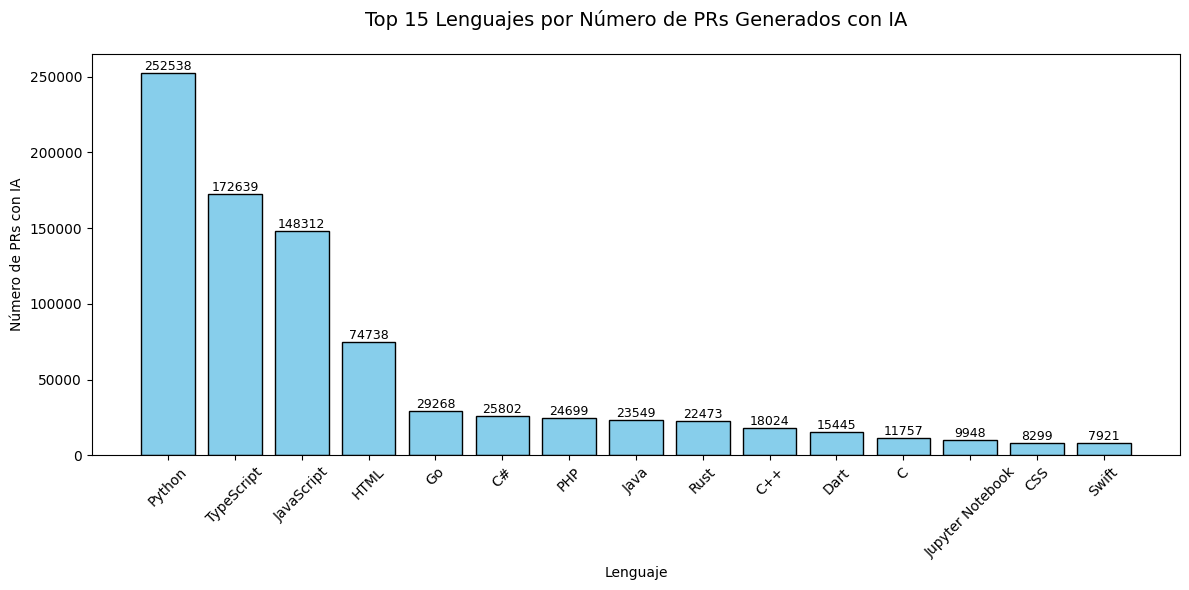

In [62]:
# ========================================
# 3. GRAFICO: Lenguajes
# ========================================
plt.figure(figsize=(12, 6))
bars = plt.bar(top_lang.index, top_lang['total_ai_prs'], color='skyblue', edgecolor='black')
plt.title('Top 15 Lenguajes por Número de PRs Generados con IA', fontsize=14, pad=20)
plt.ylabel('Número de PRs con IA')
plt.xlabel('Lenguaje')
plt.xticks(rotation=45)

# Etiquetas en barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [63]:
# ========================================
# 4. TOP LICENCIAS
# ========================================
license_summary = repos_with_ai.groupby('license').agg(
    num_repos=('repo_id', 'count'),
    total_ai_prs=('ai_prs', 'sum')
).round(2)

top_license = license_summary.sort_values('total_ai_prs', ascending=False).head(10)

print("\nTOP 10 LICENCIAS POR PRs CON IA:")
display(top_license)


TOP 10 LICENCIAS POR PRs CON IA:


,num_repos,total_ai_prs
license,,
MIT,22945,260927
NOASSERTION,4165,59363
Apache-2.0,5895,40660
GPL-3.0,3295,26567
AGPL-3.0,1098,8228
ISC,140,4972
BSD-2-Clause,166,4532
Unlicense,309,3568
GPL-2.0,459,3239


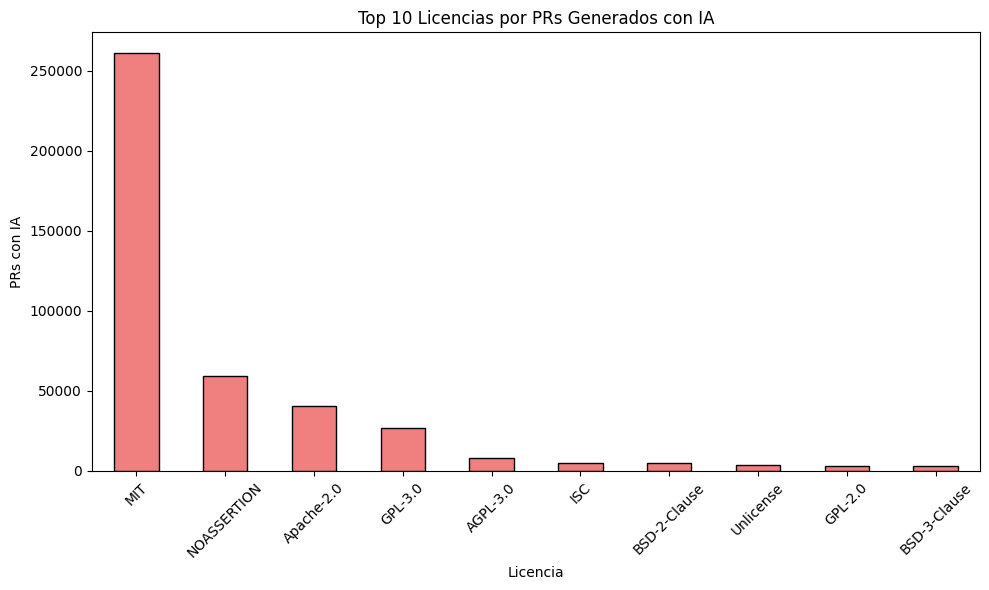

In [64]:
# ========================================
# 5. GRAFICO: Licencias
# ========================================
plt.figure(figsize=(10, 6))
top_license['total_ai_prs'].plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Top 10 Licencias por PRs Generados con IA')
plt.ylabel('PRs con IA')
plt.xlabel('Licencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
# ========================================
# 6. AGENTES POR LENGUAJE (Top 10)
# ========================================
pr_with_lang = all_pr_df.merge(repo_features[['repo_id', 'language']], on='repo_id')
top_langs = top_lang.index[:10]

agent_lang = (
    pr_with_lang[pr_with_lang['language'].isin(top_langs)]
    .groupby(['language', 'agent'])
    .size()
    .unstack(fill_value=0)
)

agent_lang_pct = agent_lang.div(agent_lang.sum(axis=1), axis=0) * 100
agent_lang_pct = agent_lang_pct.round(1)

print("\nAGENTES POR LENGUAJE (%):")
display(agent_lang_pct)


AGENTES POR LENGUAJE (%):


agent,Claude_Code,Copilot,Cursor,Devin,OpenAI_Codex
language,,,,,
C#,0.2,18.1,1.6,0.9,79.1
C++,0.4,6.7,1.8,3.2,87.9
Go,0.8,6.9,1.7,3.0,87.6
HTML,0.9,4.6,4.0,1.0,89.5
Java,0.2,7.2,3.0,1.9,87.7
JavaScript,0.2,3.8,3.3,1.4,91.3
PHP,0.2,4.3,2.4,1.8,91.2
Python,0.4,3.3,2.3,2.2,91.8
Rust,1.4,6.2,2.4,4.1,85.9


In [66]:
# ========================================
# 8. RESUMEN FINAL
# ========================================
print("\n" + "="*60)
print("RQ3: ADOPCIÓN DE IA EN PRs")
print("="*60)
print(f"→ Lenguaje líder: {top_lang.index[0]} ({top_lang.iloc[0]['total_ai_prs']:,} PRs)")
print(f"→ Licencia líder: {top_license.index[0]} ({top_license.iloc[0]['total_ai_prs']:,} PRs)")
print(f"→ Agente más usado: {all_pr_df['agent'].value_counts().idxmax()}")
print("\nInsight: Aunque todos los PRs son con IA, Python y MIT dominan → ecosistema ideal para experimentación.")


RQ3: ADOPCIÓN DE IA EN PRs
→ Lenguaje líder: Python (252,538.0 PRs)
→ Licencia líder: MIT (260,927 PRs)
→ Agente más usado: OpenAI_Codex

Insight: Aunque todos los PRs son con IA, Python y MIT dominan → ecosistema ideal para experimentación.
